# poverty vs opioids


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

In [3]:
#get census and opioid data
census_df = pd.read_csv('data/censusData20181217.csv')
opioid_df = pd.read_csv('data/districtdata.csv')
#voting_df = pd.read_csv('../uwi/data/reps_short_list.csv')
ethnicity_df = pd.read_csv("data/censusbyrace.csv")
FIPS_df = pd.read_csv("data/FIPS.csv")
ethnicity_df.head()
ethnicity_df = pd.merge(ethnicity_df, FIPS_df, left_on = 'State', right_on='state', how = 'left')
ethnicity_df['State_Disct'] = ethnicity_df['Abbrev'] + "-" + ethnicity_df['District'].astype(str)
ethnicity_df.head()

,Unnamed: 0,Total,White,Hispanic/Latin,African/American,Asian,State,District,StateName,Abbrev,state,State_Disct
0,0,704457,461122,21318.0,192647.0,NaN,1,1,Alabama,AL,1,AL-1
1,1,681621,417538,23757.0,219450.0,7813.0,1,2,Alabama,AL,1,AL-2
2,2,709482,480942,21499.0,186240.0,13838.0,1,3,Alabama,AL,1,AL-3
3,3,683273,569265,45555.0,48274.0,NaN,1,4,Alabama,AL,1,AL-4
4,4,712529,517608,36075.0,127192.0,10823.0,1,5,Alabama,AL,1,AL-5


In [4]:
#STATEFP	DISTRICT, state	cDistrict, get just date rates and merge
# drugdeathrate: Drug-related Deaths per 100,000
opioidr_df_change = opioid_df.rename(columns={'STATEFP': 'state', 'DISTRICT':'cDistrict', 'VALUE' : 'Deaths2014'})
oDeaths_df_2014 = opioidr_df_change[(opioidr_df_change['INDICATOR']=='drugdeathrate')& (opioidr_df_change['YEAR']==2013)].copy()
oDeaths_df_2014['State_Disct'] = oDeaths_df_2014['STATEABBREVIATION'] + "-" + oDeaths_df_2014['cDistrict'].astype(str)
oDeaths_df_2014.head()
df_2014 = oDeaths_df_2014[['State_Disct', 'Deaths2014']]
df_2014.head()


,State_Disct,Deaths2014
79827,AL-1,13.5
79841,AL-2,2.2
79855,AL-3,4.9
79869,AL-4,15.7
79883,AL-5,5.4


In [5]:
#STATEFP	DISTRICT, state	cDistrict, get just date rates and merge
# drugdeathrate: Drug-related Deaths per 100,000
opioidr_df= opioid_df.rename(columns={'STATEFP': 'state', 'DISTRICT':'cDistrict'})
oDeaths_df= opioidr_df[(opioidr_df['INDICATOR']=='drugdeathrate')& (opioidr_df['YEAR']==2016)]
merged_df=pd.merge(census_df, oDeaths_df, on=['state', 'cDistrict'])
merged_df['State_Disct'] = merged_df['STATEABBREVIATION'] + "-" + merged_df['cDistrict'].astype(str)

#merged_df = pd.merge(merged_df,voting_df, on = 'State_Disct')
merged_df = pd.merge(merged_df, ethnicity_df, on = 'State_Disct')
merged_df = pd.merge(merged_df, df_2014, on = 'State_Disct')
merged_df['Change'] = (merged_df['VALUE'] - merged_df['Deaths2014'])/merged_df['Deaths2014']
merged_df.head()

,Unnamed: 0_x,population,mAgeTotal,mAgeM,mAgeF,state_x,cDistrict,schoolTotal,No Schooling,Nursery,...,Hispanic/Latin,African/American,Asian,State,District,StateName,Abbrev,state_y,Deaths2014,Change
0,0,704457,39.6,38.3,41.0,1,1,483628,6173,0,...,21318.0,192647.0,NaN,1,1,Alabama,AL,1,13.5,-0.059259
1,1,681621,38.2,36.7,40.1,1,2,464210,5620,0,...,23757.0,219450.0,7813.0,1,2,Alabama,AL,1,2.2,-0.863636
2,2,709482,38.3,36.6,39.8,1,3,472077,7650,0,...,21499.0,186240.0,13838.0,1,3,Alabama,AL,1,4.9,0.387755
3,3,683273,40.7,39.7,42.0,1,4,472340,11335,137,...,45555.0,48274.0,NaN,1,4,Alabama,AL,1,15.7,-0.254777
4,4,712529,40.1,38.4,41.8,1,5,490229,6742,76,...,36075.0,127192.0,10823.0,1,5,Alabama,AL,1,5.4,1.129630


In [6]:
merged_df['death_rate_group'] = pd.qcut(merged_df['VALUE'], 5, labels=False)
merged_df['death_rate_change_group'] = pd.qcut(merged_df['Change'], 5, labels=False)
merged_df['PercBelowPovLine'] = merged_df['psUTotal']/merged_df['population'] #poverty status, income below poverty level
merged_df['PercAbovePovLine'] = merged_df['psOTotal']/merged_df['population'] #poverty status, income above poverty level
merged_df['PercCollege'] = (merged_df['Bachelors'] + merged_df['Masters'] + merged_df['ProfSchool'] + merged_df['Doctorate'])/merged_df['population']
merged_df['PercWhite'] = merged_df['White']/merged_df['population']
merged_df['PercInsured'] = merged_df['healthTotal']/merged_df['population']
merged_df['PercWhite_Black'] = (merged_df['White'] + merged_df['African/American'])/merged_df['population']
merged_df['PercWhiteGroup'] = pd.qcut(merged_df['PercWhite'], 3, labels=False)
merged_df['PercCollegeGroup'] = pd.qcut(merged_df['PercCollege'], 3, labels=False)
merged_df['PercBelowPovLineGroup'] = pd.qcut(merged_df['PercBelowPovLine'], 3, labels=False)
merged_df['PercWhite_College'] = merged_df['PercCollege'] + merged_df['PercWhite']

merged_df.head()

,Unnamed: 0_x,population,mAgeTotal,mAgeM,mAgeF,state_x,cDistrict,schoolTotal,No Schooling,Nursery,...,PercBelowPovLine,PercAbovePovLine,PercCollege,PercWhite,PercInsured,PercWhite_Black,PercWhiteGroup,PercCollegeGroup,PercBelowPovLineGroup,PercWhite_College
0,0,704457,39.6,38.3,41.0,1,1,483628,6173,0,...,0.172307,0.804459,0.165026,0.654578,0.981156,0.928047,1,0,2,0.819604
1,1,681621,38.2,36.7,40.1,1,2,464210,5620,0,...,0.186929,0.781241,0.148424,0.612566,0.970255,0.934519,1,0,2,0.760990
2,2,709482,38.3,36.6,39.8,1,3,472077,7650,0,...,0.159948,0.810558,0.151498,0.677878,0.982186,0.940379,1,0,2,0.829376
3,3,683273,40.7,39.7,42.0,1,4,472340,11335,137,...,0.175909,0.811796,0.117700,0.833144,0.990856,0.903795,2,0,2,0.950844
4,4,712529,40.1,38.4,41.8,1,5,490229,6742,76,...,0.144759,0.831767,0.208269,0.726438,0.984039,0.904946,1,1,1,0.934707


In [7]:
max_q = merged_df['death_rate_group'].max()
min_q = merged_df['death_rate_group'].min()

#merged_df = merged_df[(merged_df['death_rate_group'] == min_q) | (merged_df['death_rate_group'] == max_q)]
merged_df.columns
merged_df.fillna(0, inplace=True)

In [8]:
merged_df['death_rate_group'] = merged_df['death_rate_group'].astype(int)
merged_df['PercBelowPovLineGroup'] = merged_df['PercBelowPovLineGroup'].astype(int)
merged_df['VALUE'] = merged_df['VALUE'].astype(int)

In [9]:
cat_1 = merged_df[merged_df['death_rate_group'] == max_q]
cat_2 = merged_df[merged_df['death_rate_group'] == min_q]
cat_all = cat_1.append(cat_2)

change_cat1 = merged_df[merged_df['death_rate_change_group'] == max_q]
change_cat2 = merged_df[merged_df['death_rate_change_group'] == min_q]

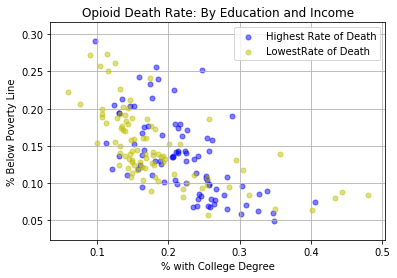

In [10]:
plt.scatter(x = cat_1['PercCollege'], y = cat_1['PercBelowPovLine'], s = 25, c ='b', alpha = .50, label = 'Highest Rate of Death')
plt.scatter(x = cat_2['PercCollege'], y = cat_2['PercBelowPovLine'], s = 25, c ='y', alpha = .50, label = 'LowestRate of Death')
plt.legend(loc = 'best')
plt.xlabel('% with College Degree', fontsize=10)
plt.ylabel('% Below Poverty Line', fontsize=10)
plt.title('Opioid Death Rate: By Education and Income', fontsize=12)
plt.grid(True)
plt.savefig("Charts/Education_Income.png")


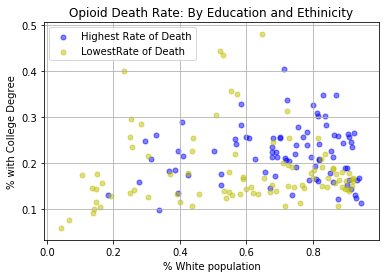

In [11]:
plt.scatter(x = cat_1['PercWhite'], y = cat_1['PercCollege'], s = 25, c ='b', alpha = .50, label = 'Highest Rate of Death')
plt.scatter(x = cat_2['PercWhite'], y = cat_2['PercCollege'], s = 25, c ='y', alpha = .50, label = 'LowestRate of Death')
plt.legend(loc = 'best')
plt.xlabel('% White population', fontsize=10)
plt.ylabel('% with College Degree', fontsize=10)
plt.title('Opioid Death Rate: By Education and Ethinicity', fontsize=12)
plt.grid(True)
plt.savefig("Charts/Education_Ethinicty.png")

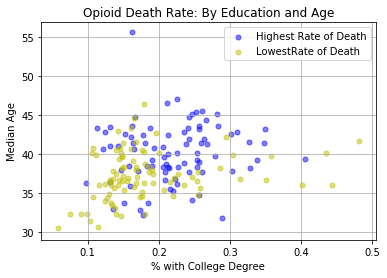

In [12]:
plt.scatter(x = cat_1['PercCollege'], y = cat_1['mAgeTotal'], s = 25, c ='b', alpha = .50, label = 'Highest Rate of Death')
plt.scatter(x = cat_2['PercCollege'], y = cat_2['mAgeTotal'], s = 25, c ='y', alpha = .50, label = 'LowestRate of Death')
plt.legend(loc = 'best')
plt.xlabel('% with College Degree', fontsize=10)
plt.ylabel('Median Age', fontsize=10)
plt.title('Opioid Death Rate: By Education and Age', fontsize=12)
plt.grid(True)
plt.savefig("Charts/Education_Age.png")

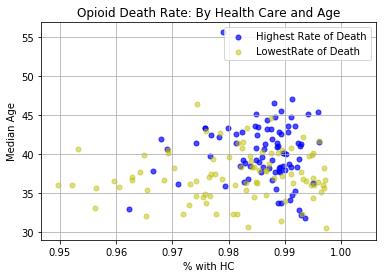

In [13]:
plt.scatter(x = cat_1['PercInsured'], y = cat_1['mAgeTotal'], s = 25, c ='b', alpha = .70, label = 'Highest Rate of Death')
plt.scatter(x = cat_2['PercInsured'], y = cat_2['mAgeTotal'], s = 25, c ='y', alpha = .50, label = 'LowestRate of Death')
plt.legend(loc = 'best')
plt.xlabel('% with HC', fontsize=10)
plt.ylabel('Median Age', fontsize=10)
plt.title('Opioid Death Rate: By Health Care and Age', fontsize=12)
plt.grid(True)
plt.savefig("Charts/HC_Age.png")

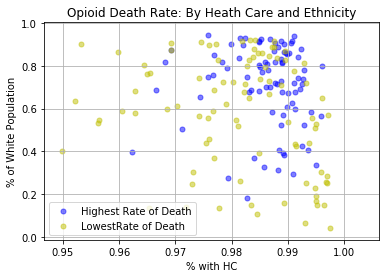

In [14]:
plt.scatter(x = cat_1['PercInsured'], y = cat_1['PercWhite'], s = 25, c ='b', alpha = .50, label = 'Highest Rate of Death')
plt.scatter(x = cat_2['PercInsured'], y = cat_2['PercWhite'], s = 25, c ='y', alpha = .50, label = 'LowestRate of Death')
plt.legend(loc = 'best')
plt.xlabel('% with HC', fontsize=10)
plt.ylabel('% of White Population', fontsize=10)
plt.title('Opioid Death Rate: By Heath Care and Ethnicity', fontsize=12)
plt.grid(True)
plt.savefig("Charts/HC_Eth.png")

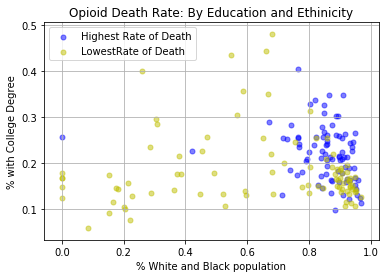

In [15]:
plt.scatter(x = cat_1['PercWhite_Black'], y = cat_1['PercCollege'], s = 25, c ='b', alpha = .50, label = 'Highest Rate of Death')
plt.scatter(x = cat_2['PercWhite_Black'], y = cat_2['PercCollege'], s = 25, c ='y', alpha = .50, label = 'LowestRate of Death')
plt.legend(loc = 'best')
plt.xlabel('% White and Black population', fontsize=10)
plt.ylabel('% with College Degree', fontsize=10)
plt.title('Opioid Death Rate: By Education and Ethinicity', fontsize=12)
plt.grid(True)
plt.savefig("Charts/Education_Ethinicty_White_Black.png")

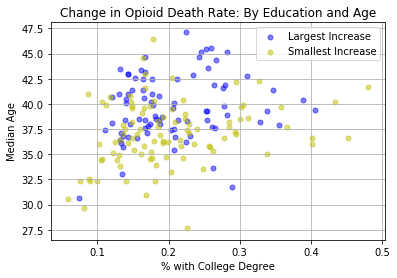

In [16]:
plt.scatter(x = change_cat1['PercCollege'], y = change_cat1['mAgeTotal'], s = 25, c ='b', alpha = .50, label = 'Largest Increase')
plt.scatter(x = change_cat2['PercCollege'], y = change_cat2['mAgeTotal'], s = 25, c ='y', alpha = .50, label = 'Smallest Increase')
plt.legend(loc = 'best')
plt.xlabel('% with College Degree', fontsize=10)
plt.ylabel('Median Age', fontsize=10)
plt.title('Change in Opioid Death Rate: By Education and Age', fontsize=12)
plt.grid(True)
plt.savefig("Charts/Education_Age_Change.png")

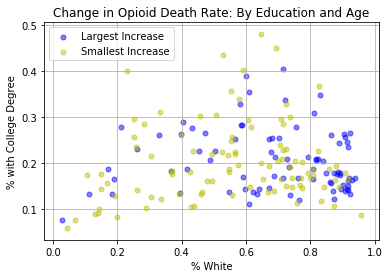

In [17]:
plt.scatter(x = change_cat1['PercWhite'], y = change_cat1['PercCollege'], s = 25, c ='b', alpha = .50, label = 'Largest Increase')
plt.scatter(x = change_cat2['PercWhite'], y = change_cat2['PercCollege'], s = 25, c ='y', alpha = .50, label = 'Smallest Increase')
plt.legend(loc = 'best')
plt.xlabel('% White', fontsize=10)
plt.ylabel('% with College Degree', fontsize=10)
plt.title('Change in Opioid Death Rate: By Education and Age', fontsize=12)
plt.grid(True)
plt.savefig("Charts/Education_Ethinicity_Change.png")

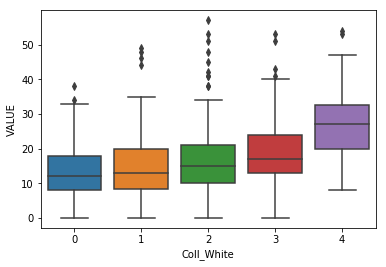

In [18]:
merged_df['Coll_White'] = merged_df['PercCollegeGroup'] + merged_df['PercWhiteGroup']
sns.boxplot(y = merged_df['VALUE'], x = merged_df['Coll_White'])

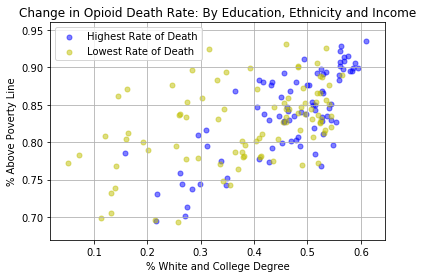

In [20]:
plt.scatter(x = cat_1['PercWhite_College']/2, y = cat_1['PercAbovePovLine'], s = 25, c ='b', alpha = .50, label = 'Highest Rate of Death')
plt.scatter(x = cat_2['PercWhite_College']/2, y = cat_2['PercAbovePovLine'], s = 25, c ='y', alpha = .50, label = 'Lowest Rate of Death')
plt.legend(loc = 'best')
plt.xlabel('% White and College Degree', fontsize=10)
plt.ylabel('% Above Poverty Line', fontsize=10)
plt.title('Change in Opioid Death Rate: By Education, Ethnicity and Income', fontsize=12)
plt.grid(True)
plt.savefig("Charts/Education_Ethinicity_Income.png")